# Match state
Trying to generate a way to represent the current state of the game in a vector that can be plugged into modeling methods.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import leaguedata as ld

#Progress bars wooo
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import Markdown

In [192]:
matches = ld.get_all_matches()
print(len(matches))


def get_match_state(match_num, min_num):
    match_state = []
    columns = []
    
    match_state.append(match_num)
    columns.append("match_num")
    match_state.append(min_num)
    columns.append("min_num")
    
    match = matches[match_num]
    
    #gold_types = ['goldblue', 'goldred', 'goldblueTop', 
    #              'goldblueJungle', 'goldblueMiddle', 'goldblueADC', 
    #              'goldblueSupport', 'goldredTop', 'goldredJungle',
    #              'goldredMiddle', 'goldredADC', 'goldredSupport']
    
    gold_types = ['golddiff']
    
    for gold_type in gold_types:
        gold = match.gold_type(gold_type)[min_num]
        match_state.append(gold)
        columns.append(gold_type)
        

    bkills = matches[match_num].blue_kills().values
    num_bkills = 0
    for kill in bkills:
        if(kill[2] < min_num):
            num_bkills +=1
            
    match_state.append(num_bkills)
    columns.append("num_bkills")
    
    rkills = matches[match_num].red_kills().values
    num_rkills = 0
    for kill in rkills:
        if(kill[2] < min_num):
            num_rkills +=1
            
    match_state.append(num_rkills)
    columns.append("num_rkills")
    
    bturrets = matches[match_num].blue_structures().values
    num_bturrets = 0
    num_binhibs = 0
    for turret in bturrets:
        if(turret[2] < min_num and turret[1] == 'bTowers'):
            num_bturrets +=1
        if(turret[2] < min_num and turret[1] == 'bInhibs'):
            num_binhibs +=1
            
    match_state.append(num_bturrets)
    columns.append("num_bturrets")
    match_state.append(num_binhibs)
    columns.append("num_binhibs")
    
    rturrets = matches[match_num].blue_structures().values
    num_rturrets = 0
    num_rinhibs = 0
    for turret in rturrets:
        if(turret[2] < min_num and turret[1] == 'rTowers'):
            num_rturrets +=1
        if(turret[2] < min_num and turret[1] == 'rInhibs'):
            num_rinhibs +=1
            
    match_state.append(num_rturrets)
    columns.append("num_rturrets")
    match_state.append(num_rinhibs)
    columns.append("num_rinhibs")
    
    df = pd.DataFrame([np.array(match_state)], columns=columns)
    
    df.index = [match_num]
    
    return df

7620


In [3]:
test_match_num = 10

state = get_match_state(test_match_num, 10)

state

,match_num,min_num,goldblue,goldred,goldblueTop,goldblueJungle,goldblueMiddle,goldblueADC,goldblueSupport,goldredTop,goldredJungle,goldredMiddle,goldredADC,goldredSupport,num_bkills,num_rkills,num_bturrets,num_binhibs,num_rturrets,num_rinhibs
10,10,10,13931,13397,3090,2848,3087,3076,1830,2878,2813,2829,3086,1791,0,0,0,0,0,0


In [4]:
int(matches[0].bResult())

1

# Predicting match outcome given game state

### Generate X and y

In [193]:
state_list = pd.DataFrame() # 
y = []

num_matches = 500

print("Generating list of match states..")
prog = IntProgress(min=0, max=num_matches)
display(prog)

for match_num in range(0, num_matches):
    match_length = matches[match_num].length()
    
    prog.value += 1
    
    for i in np.arange(5, match_length, 5):
        state_list = state_list.append(get_match_state(match_num, i))
        y.append(int(matches[match_num].bResult()))

state_list.index = range(len(state_list))        

state_list

Generating list of match states..


IntProgress(value=0, max=500)

,match_num,min_num,golddiff,num_bkills,num_rkills,num_bturrets,num_binhibs,num_rturrets,num_rinhibs
0,0.0,5.0,-431.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,-1044.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15.0,-611.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,20.0,987.0,4.0,3.0,4.0,0.0,0.0,0.0
4,0.0,25.0,1527.0,4.0,3.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3405,499.0,25.0,-227.0,3.0,4.0,4.0,0.0,0.0,0.0
3406,499.0,30.0,511.0,3.0,4.0,5.0,0.0,0.0,0.0
3407,499.0,35.0,-4926.0,3.0,7.0,5.0,0.0,0.0,0.0
3408,499.0,40.0,-7910.0,3.0,8.0,5.0,0.0,0.0,0.0


In [238]:
y = np.array(y)

# Drop the unesscasary values from state list
X = state_list.drop(columns=["match_num"])

# Chop off early match values
X = state_list[state_list["min_num"] > 10]
new_y = y[list(state_list["min_num"] > 10)]

In [239]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, new_y, random_state=1)
regr = MLPClassifier(random_state=3, max_iter=1500, hidden_layer_sizes=(500, 200, 50, 5, 50, 200))
regr.fit(X_train, y_train)
print("Training score: ")
print(regr.score(X_train, y_train))
print("Testing score: ")
print(regr.score(X_test, y_test))

Training score: 
0.7946873270614278
Testing score: 
0.7645107794361525


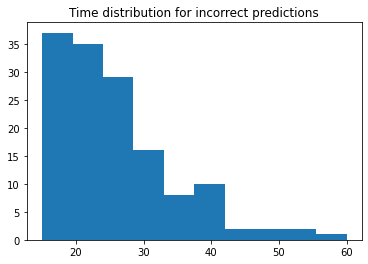

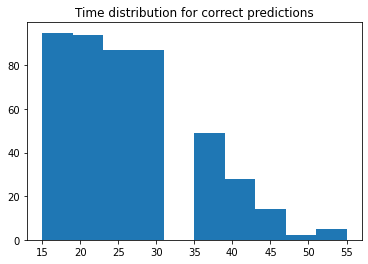

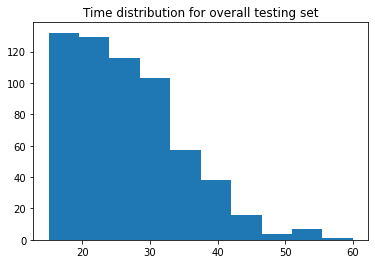

In [240]:
test_match = 11

a = regr.predict(X_test)
b = y_test

plt.hist(X_test[a != b]['min_num'])
plt.title("Time distribution for incorrect predictions")
plt.show()

plt.hist(X_test[a == b]['min_num'])
plt.title("Time distribution for correct predictions")
plt.show()

plt.hist(X_test['min_num'])
plt.title("Time distribution for overall testing set")
plt.show()

# Predicting game states

In [352]:
state_list = get_match_state(test_match_num, 0)

num_matches = 1000

print("Generating list of match states..")
prog = IntProgress(min=0, max=num_matches)
display(prog)

for match_num in range(0, num_matches):
    match_length = matches[match_num].length()
    
    prog.value += 1
    
    for i in np.arange(5, match_length, 5):
        state_list = state_list.append(get_match_state(match_num, i))

state_list.index = range(len(state_list))        

state_list

Generating list of match states..


IntProgress(value=0, max=1000)

,match_num,min_num,goldblue,goldred,goldblueTop,goldblueJungle,goldblueMiddle,goldblueADC,goldblueSupport,goldredTop,goldredJungle,goldredMiddle,goldredADC,goldredSupport,num_bkills,num_rkills,num_bturrets,num_binhibs,num_rturrets,num_rinhibs
0,10.0,0.0,2415.0,2415.0,475.0,475.0,475.0,475.0,515.0,475.0,475.0,475.0,475.0,515.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,5.0,6171.0,6602.0,1058.0,1276.0,1307.0,1453.0,1077.0,1284.0,1429.0,1378.0,1469.0,1042.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,10.0,12677.0,13721.0,2249.0,2707.0,3057.0,2851.0,1813.0,3011.0,3031.0,2896.0,2976.0,1807.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,15.0,19952.0,20563.0,3935.0,4074.0,5045.0,4312.0,2586.0,4725.0,4535.0,4250.0,4459.0,2594.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,20.0,30690.0,29703.0,6234.0,6034.0,7632.0,6604.0,4186.0,6751.0,6413.0,5931.0,7000.0,3608.0,4.0,3.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,999.0,10.0,14571.0,14201.0,3268.0,2903.0,3293.0,3171.0,1936.0,3215.0,2614.0,3442.0,2958.0,1972.0,1.0,0.0,0.0,0.0,0.0,0.0
6796,999.0,15.0,23765.0,21789.0,5481.0,4487.0,5253.0,5324.0,3220.0,5030.0,4016.0,5582.0,4190.0,2971.0,4.0,2.0,2.0,0.0,0.0,0.0
6797,999.0,20.0,33206.0,29347.0,7839.0,6103.0,7489.0,7379.0,4396.0,6403.0,5432.0,7657.0,5686.0,4169.0,6.0,3.0,4.0,0.0,0.0,0.0
6798,999.0,25.0,45319.0,37448.0,10529.0,8584.0,9736.0,10233.0,6237.0,8242.0,7003.0,9314.0,7255.0,5634.0,11.0,6.0,7.0,1.0,0.0,0.0


In [26]:
state_list.loc[2]['match_num']

match_num
min_num
goldblue
goldred
goldblueTop
goldblueJungle
goldblueMiddle
goldblueADC
goldblueSupport
goldredTop
goldredJungle
goldredMiddle
goldredADC
goldredSupport
num_bkills
num_rkills
num_bturrets
num_binhibs


In [353]:
X = get_match_state(0, 0)
y = get_match_state(0, 5)

for i in range(0, len(state_list)-1):
    current_state = state_list.loc[i]
    next_state = state_list.loc[i+1]
    
    match_num = current_state['match_num']
    next_num = next_state['match_num']
    
    if(match_num == next_num):
        X = X.append(current_state, ignore_index=True)
        y = y.append(next_state, ignore_index=True)
        
X = X.drop(columns=['match_num'])
y = y.drop(columns=['match_num'])

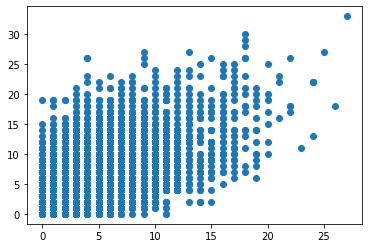

In [354]:
plt.scatter(X['num_bkills'], y['num_rkills'])

In [361]:
len(X)

5800

In [368]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=1500, hidden_layer_sizes=(100, 10, 100, 10, 100))
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

-40.300098558810674


In [329]:
test_num = 20

print("X test")
print(X_test.values[test_num].astype(int))

print("Y test")
print(y_test.values[test_num].astype(int))

print("Y predicted")
print(regr.predict([X_test.values[test_num]]).astype(int))

X test
[   25 39283 36742  7455  8261  8240  9731  5596  7536  6510  8597  9112
  4987     8     4     4     0     0     0]
Y test
[   30 47423 43325  8990 10357 10033 11594  6449  9209  7135 10312 10921
  5748    11     6     4     0     0     0]
Y predicted
[[   29 48558 45203  9902  9390 11063 11548  6750  9158  8470 10524 10821
   6181     8     8     4     0    -1     0]]


[[   79 65557 68525 13691 12814 14687 14931  9381 14379 13520 15915 15689
   9936    -4   -11    -2    -2    -1   -36]]


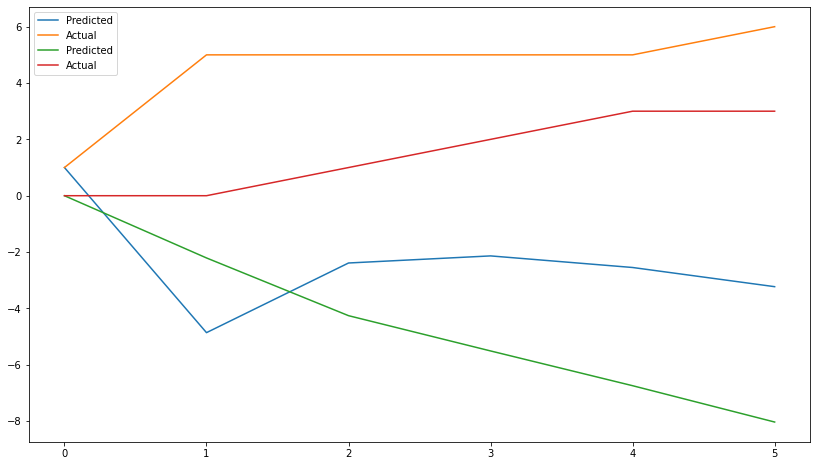

In [367]:
test_start = 1003
sim_length = 10

item = 10

match_sim = [X.values[test_start]]

match_ref = y.values[(test_start-1):(test_start+sim_length-1)]

match_values = []

for i in range(0, sim_length-1):
    match_values.append(match_sim[0])
    match_sim = regr.predict(match_sim)
    
    if match_ref[i, 0] > match_ref[i+1, 0]:
        break

match_values = np.array(match_values)
match_ref = y.values[(test_start-1):(test_start+len(match_values)-1)]

match_length = len(match_values)


plt.figure(figsize = [14,8])
plt.plot(range(0, match_length), match_values[:, 13], label="Predicted")
plt.plot(range(0, match_length), match_ref[:, 13], label = "Actual")

plt.plot(range(0, match_length), match_values[:, 14], label="Predicted")
plt.plot(range(0, match_length), match_ref[:, 14], label = "Actual")

plt.legend()

print(match_sim.astype(int))